In [1]:
import numpy as np
import pandas as pd
import os
import json
import csv
from keras import models
from keras import metrics
from keras import optimizers
from keras import layers

In [2]:
outputPath = "./openpose/openpose/output"

In [3]:
frameCounter = []

totalData = []
for path in os.listdir(outputPath):
    fullPath = os.path.join(outputPath, path)    
    Data = pd.read_json(fullPath) 
    pData = Data["people"]
    poseData = []
    if len(pData) != 0:                    
        poseData.append(pData[0]["pose_keypoints_2d"])
        totalData+=poseData
    else:
        poseData = [0] * 75
        totalData.append(poseData)
    frameCounter.append(path.split('.')[0])      

In [4]:
# now we normalize our data
for data in totalData:
    for i in range(0, 75, 3):
        data[i] = float(data[i]) / 320
        data[i + 1] = float(data[i + 1]) / 240


In [5]:
totalLabel = pd.read_csv("urLabel.csv", header=None)

In [6]:
frameRecords = {}
for name in frameCounter:
    names = name.split("_")
    videoNumString = names[0][5:7]
    videoNum = int(videoNumString)
    if videoNum not in frameRecords:
        frameRecords[videoNum] = []
    frameRecords[videoNum].append(int(names[1]))

In [7]:
for index, row in totalLabel.iterrows():
    totalLabel.loc[index, 1] -= 1

In [8]:
rowsToDrop = []
for index, row in totalLabel.iterrows():
    frameName = row[0]
    videoNum = int(frameName.split("-")[1])            
    if int(row[1]) not in frameRecords[videoNum]:        
        rowsToDrop.append(index)
    else:
        if row[2] == 0:
            totalLabel.loc[index, 2] = 1
            
labelData = totalLabel.drop(totalLabel.index[rowsToDrop]).loc[:, [0, 1, 2]]

In [9]:
labelData

,0,1,2
0,fall-01,0,-1
1,fall-01,1,-1
2,fall-01,2,-1
3,fall-01,3,-1
4,fall-01,4,-1
...,...,...,...
2978,fall-30,53,1
2979,fall-30,54,1
2980,fall-30,55,1
2981,fall-30,56,1


In [10]:
totalLabel = []
for index, row in labelData.iterrows():
    totalLabel.append(int(row[2]))

In [11]:
print(len(totalData))
print(len(totalData[0]))
print(len(totalLabel))

2635
75
2635


In [13]:
np.random.shuffle(totalData)
# now we split the data
test_data = totalData[:len(totalData) // 9]
train_data = totalData[len(totalData) // 9:]
test_label = totalLabel[:len(totalData) // 9]
train_label = totalLabel[len(totalData) // 9:]
print(len(train_data))
print(len(test_data))
print(len(train_label))
print(len(test_label))
print(train_data[0])
print(train_label[0])

2343
292
2343
292
[0.533309375, 0.4025575, 0.879093, 0.5293281249999999, 0.4404833333333333, 0.9045700000000001, 0.49879687500000003, 0.44305, 0.87509, 0.49462812500000003, 0.49465, 0.810735, 0.490703125, 0.5514291666666666, 0.836796, 0.561775, 0.440375, 0.8620249999999999, 0.575940625, 0.494625, 0.8291200000000001, 0.578015625, 0.5540416666666667, 0.8607469999999999, 0.53134375, 0.5542458333333333, 0.784472, 0.513053125, 0.5568458333333334, 0.803654, 0.52310625, 0.6623375, 0.786293, 0.529190625, 0.7516333333333333, 0.8044789999999999, 0.5536187499999999, 0.5542125, 0.772852, 0.54559375, 0.6596208333333333, 0.838287, 0.54755625, 0.7543375, 0.7958149999999999, 0.52730625, 0.39709500000000003, 0.888408, 0.5414375, 0.3970829166666666, 0.855993, 0.515028125, 0.39177791666666667, 0.788401, 0.54553125, 0.39450833333333335, 0.519791, 0.5535875, 0.7814208333333333, 0.7348669999999999, 0.5617125, 0.7733666666666666, 0.808962, 0.5455125, 0.7678166666666667, 0.619064, 0.52925, 0.7733541666666667,

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(128,(3,3), padding='same', activation='relu', input_shape=(3, 25, 1)))
model.add(layers.BatchNormalization(1))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization(1))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-4), 
                  metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 3, 25, 128)        1280      
_________________________________________________________________
batch_normalization_10 (Batc (None, 3, 25, 128)        12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 25, 128)        147584    
_________________________________________________________________
batch_normalization_11 (Batc (None, 3, 25, 128)        12        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 12, 128)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

In [20]:
# we will start with CNN model with 10-fold
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(128,(3,3), padding='same', activation='relu', input_shape=(3, 25, 1)))
    model.add(layers.BatchNormalization(1))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization(1))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.RMSprop(lr=1e-4), 
                  metrics=['acc'])
    return model

In [15]:
data_train_array = np.array(train_data)
label_train_array = np.array(train_label)
data_train_array = data_train_array.reshape((len(data_train_array), 
                                             3, 
                                             int(len(data_train_array[0])/3), 
                                             1))
data_train_array.shape

(2343, 3, 25, 1)

In [24]:
model = build_model()
history = model.fit(data_train_array, label_train_array, epochs=50, batch_size=8, 
         validation_split=0.2)

Epoch 1/50
235/235 [==============================] - 5s 18ms/step - loss: 0.6281 - acc: 0.0477 - val_loss: 0.5690 - val_acc: 0.0171
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.4838 - acc: 0.0246 - val_loss: 0.4243 - val_acc: 0.0000e+00
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.4947 - acc: 0.0205 - val_loss: 0.3406 - val_acc: 0.0000e+00
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.4084 - acc: 0.0095 - val_loss: 0.3600 - val_acc: 0.0000e+00
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2961 - acc: 0.0287 - val_loss: 0.7342 - val_acc: 0.2388
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2979 - acc: 0.0520 - val_loss: 0.3988 - val_acc: 0.0085
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1312 - acc: 0.0429 - val_loss: 0.4245 - val_acc: 0.0043
Epoch 8/50
235/235 [==============================] - 2s 7ms/st

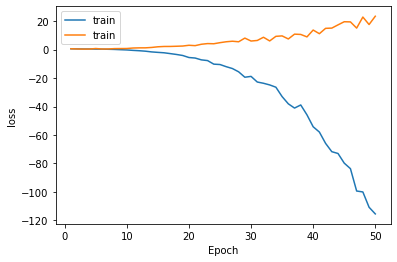

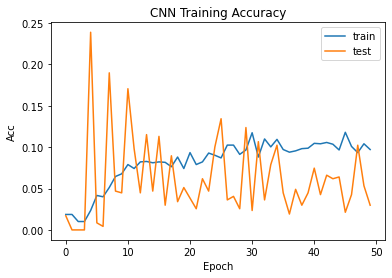

In [27]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'train')
plt.plot(epochs, history.history['val_loss'], label = 'train')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="test")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("CNN Training Accuracy")
plt.legend()
plt.show()